In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import integrate
from car_park_functions import *
import math

In [92]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=3
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 4 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  3516.6577380952117
Friday area:  3082.0952380952285
Weekend area:  523.6141262509632
Weekday maximum:  144.64285714285714
Friday maximum:  140.71428571428572
Weekend maximum:  26.775981524249424


## MATHEMATICAL MODEL - CDF Subtraction

In [93]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

#parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

errors = np.ones(np.shape(training_weekdays_norm))

parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*wd_length)

optimal_params_weekdaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_weekdays_norm,training_weekdays_isfull,errors),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})

Optimization terminated successfully.
         Current function value: 3.956169
         Iterations: 18011
         Function evaluations: 21544


In [94]:
import math 
var_weekdaytn_time = np.mean(errors)
#var_weekdaytn = optimal_params_weekdaytn.fun/np.size(training_weekdays_norm)
stdv_weekdaytn=math.sqrt(var_weekdaytn_time)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors,0))
print('stdv per time-step')
for i in stdv_weekday30mins:
    print('\t' + str(i))

global stdv 0.05425

stdv per time-step
	0.03746052809056656
	0.03543225556164639
	0.03405658676839088
	0.034081535802153964
	0.03414029011805979
	0.03418984814776803
	0.03403270377345879
	0.03368156323617955
	0.03359496342118242
	0.0339686678466186
	0.040286117814036466
	0.044745387439933046
	0.04439509616558265
	0.06537763637070335
	0.06040352518022135
	0.0681530633676388
	0.07376925333650819
	0.044852825667649504
	0.0369074292073181
	0.041970137496073104
	0.03870520424778532
	0.03483312344194108
	0.031287294344621665
	0.028512326740591534
	0.022078568440378497
	0.020492774427577035
	0.020137971368894978
	0.02293169447119933
	0.02490546259573678
	0.0219442748048429
	0.03332558654517201
	0.04698844095953755
	0.065644179237042
	0.07658924379646348
	0.08057880450417848
	0.10028508406618325
	0.09411511566559962
	0.08568198512605227
	0.08609110491421897
	0.08139690736427749
	0.07192320086458479
	0.06495592726072583
	0.058500724786778084
	0.06255241903921294
	0.0649687711284691
	0.06699615

In [95]:
optimal_params_weekdaytn

 final_simplex: (array([[0.31383963, 0.03621748, 0.80902433, ..., 0.7261689 , 0.73093133,
        0.71026415],
       [0.31383962, 0.03621743, 0.80902429, ..., 0.72616862, 0.73093135,
        0.71026431],
       [0.31383961, 0.03621745, 0.80902433, ..., 0.72616875, 0.73093115,
        0.7102641 ],
       ...,
       [0.31383963, 0.03621744, 0.80902434, ..., 0.72616874, 0.73093142,
        0.71026423],
       [0.31383962, 0.03621747, 0.80902436, ..., 0.72616904, 0.73093146,
        0.71026411],
       [0.31383964, 0.03621744, 0.80902432, ..., 0.72616875, 0.73093142,
        0.71026431]]), array([3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
       3.95616867, 3.95616867, 3.95616867, 3.95616867, 3.95616867,
   

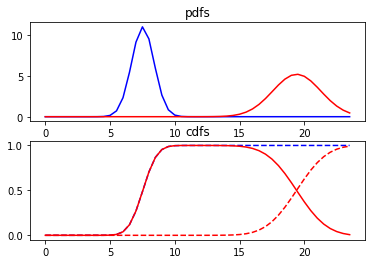

In [96]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [196]:
optimal_params_weekdayth=np.mean(optimal_params_weekdaytn.x[4:])

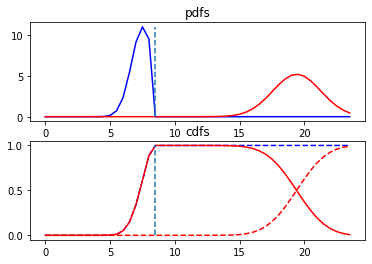

In [197]:
plot_model_tn_th(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],
              optimal_params_weekdaytn.x[3],optimal_params_weekdayth)

In [98]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.31383963, 0.03621748, 0.80902433, 0.0772256 , 0.76561431,
       0.62051281, 0.85422873, 0.86941477, 0.82320583, 0.87775692,
       0.92357488, 0.87157498, 0.8335844 , 0.83529347, 0.8482066 ,
       0.82297959, 0.83987068, 0.84802219, 0.80918356, 0.80282006,
       0.80040425, 0.79872722, 0.81020112, 0.80603411, 0.73694148,
       0.73420851, 0.7261689 , 0.72622504, 0.73035329, 0.7261689 ,
       0.73093133, 0.71026415])

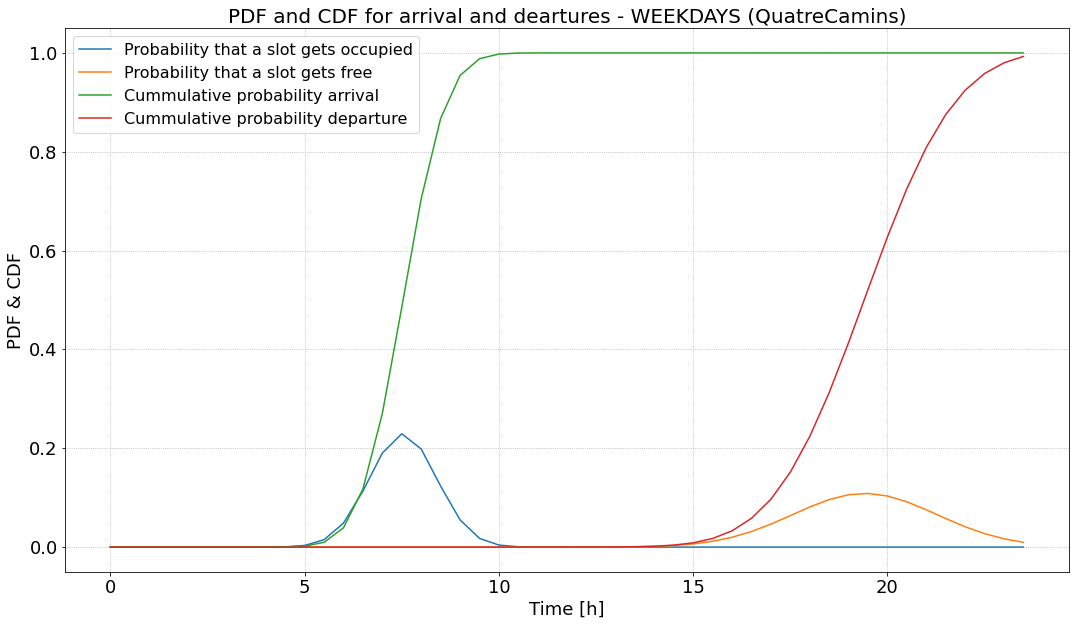

In [99]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
prototype_math_arr_weekday=cdf1_wd
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
prototype_math_dep_weekday=cdf2_wd
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd#/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

fig = plt.figure(figsize=(18,10))
plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
plt.plot(time2, cdf2_wd, label="Cummulative probability departure")
#plt.plot(time2, cdf1_wd_ap, label="Cummulative probability arrival approx")
#plt.plot(time2, cdf2_wd_ap, label="Cummulative probability departure approx")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left");


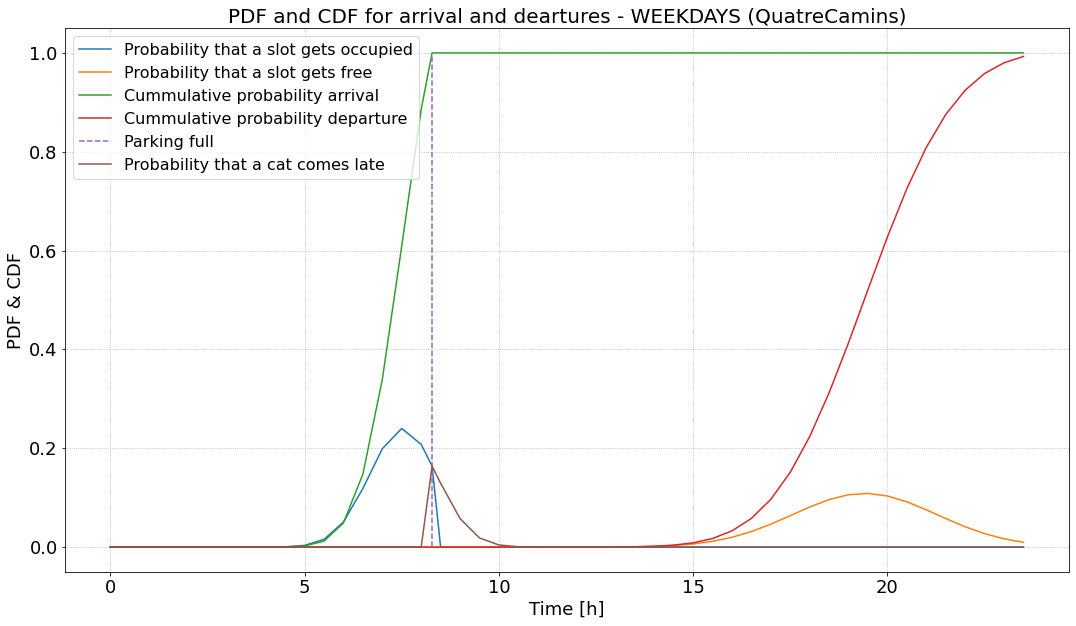

In [255]:
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])

ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdayth)
t_parking_full=np.interp(optimal_params_weekdayth,cdf1_wd,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)

tn1_wd=np.insert(tn1_wd,ix_parking_full,np.interp(t_parking_full,time2,tn1_wd))
tn1_wd_excees=tn1_wd.copy()
tn1_wd[ix_parking_full+1:] =0
tn1_wd_excees[:ix_parking_full] =0

#tn1_wd[cdf1_wd>optimal_params_weekdayth] =0
#tn1_wd_excees[cdf1_wd<optimal_params_weekdayth] =0
cdf1_wd[cdf1_wd>optimal_params_weekdayth] = optimal_params_weekdayth
cdf1_wd_plot=np.insert(cdf1_wd,ix_parking_full,optimal_params_weekdayth)

cdf1_wd = cdf1_wd/optimal_params_weekdayth
cdf1_wd_plot = cdf1_wd_plot/optimal_params_weekdayth

cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
cdf2_wd_plot=np.insert(cdf2_wd,ix_parking_full,np.interp(t_parking_full,time2,cdf2_wd))
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
resta_wd_plot = np.array(cdf1_wd_plot) - np.array(cdf2_wd_plot)
prototype_math_weekday = resta_wd#/sum(resta_wd)
prototype_math_weekday_plot = resta_wd_plot#/sum(resta_wd)
#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

fig = plt.figure(figsize=(18,10))
plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.plot(time2_th, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
plt.plot(time2_th, cdf1_wd_plot, label="Cummulative probability arrival")
plt.plot(time2_th, cdf2_wd_plot, label="Cummulative probability departure")
#plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
plt.plot(t_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
plt.plot(time2_th, tn1_wd_excees/sum(tn1_wd), label="Probability that a cat comes late")
#plt.plot(time2, cdf1_wd_ap, label="Cummulative probability arrival approx")
#plt.plot(time2, cdf2_wd_ap, label="Cummulative probability departure approx")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left");

In [239]:
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])


In [243]:
np.interp(t_parking_full,time2,cdf2_wd)

1.25044412305275e-09

In [244]:
cdf2_wd=np.insert(cdf2_wd,ix_parking_full,np.interp(t_parking_full,time2,cdf2_wd))

In [245]:
cdf2_wd

array([0.00000000e+00, 8.78946816e-25, 1.44709118e-23, 2.09964446e-22,
       2.82522678e-21, 3.53663867e-20, 4.11972965e-19, 4.46595728e-18,
       4.50558297e-17, 4.23060291e-16, 3.69738632e-15, 3.00786009e-14,
       2.27783582e-13, 1.60592079e-12, 1.05414722e-11, 6.44312384e-11,
       3.66738958e-10, 1.25044412e-09, 1.94417618e-09, 9.60043668e-09,
       4.41661007e-08, 1.89323258e-07, 7.56344135e-07, 2.81663405e-06,
       9.78013906e-06, 3.16728340e-05, 9.56969775e-05, 2.69862791e-04,
       7.10577878e-04, 1.74793909e-03, 4.01926939e-03, 8.64531417e-03,
       1.74096612e-02, 3.28554595e-02, 5.81765836e-02, 9.67899892e-02,
       1.51564224e-01, 2.23840887e-01, 3.12557269e-01, 4.13853615e-01,
       5.21442688e-01, 6.27741166e-01, 7.25435735e-01, 8.08957211e-01,
       8.75378920e-01, 9.24515596e-01, 9.58328691e-01, 9.79973161e-01,
       9.92861332e-01])

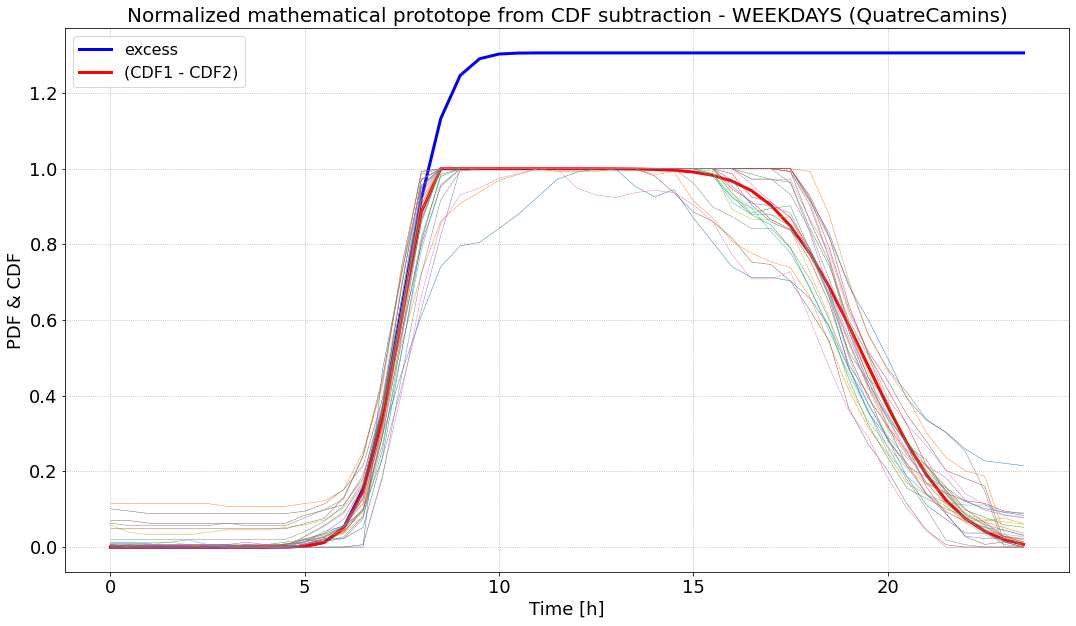

In [199]:
fig = plt.figure(figsize=(18,10))
plt.title("Normalized mathematical prototope from CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time2, prototype_math_arr_weekday/optimal_params_weekdaytn.x[4], linewidth=3, color='blue', label="excess")
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    plt.plot(time, training_weekdays_norm[i], linewidth=0.45)

plt.legend(fontsize=16, loc="upper left");

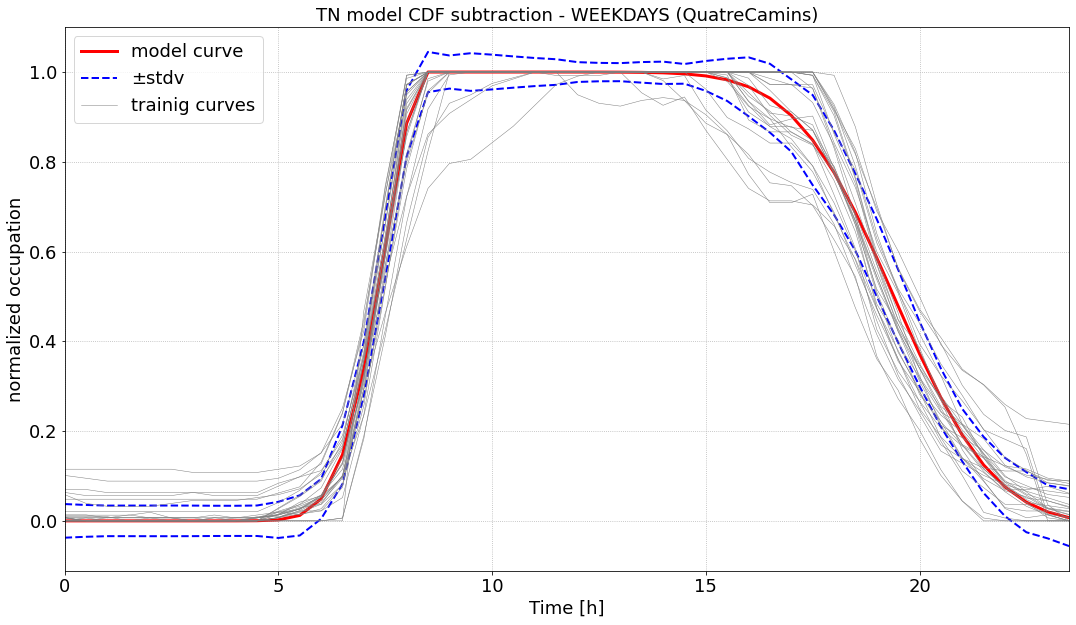

In [200]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

In [103]:
bol_plot_individual_fits = False
if bol_plot_individual_fits: 
    tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
    tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    for ii in range(0,len(training_weekdays_norm)):
        idx_th=ii+4

        cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])


        dayisFull=training_weekdays_isfull[ii]
        if dayisFull:
            print(optimal_params_weekdaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] =0
            cdf1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] = optimal_params_weekdaytn.x[idx_th]
            cdf1_wd = cdf1_wd/optimal_params_weekdaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
        prototype_math_weekday = resta_wd#/sum(resta_wd)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - weekdayS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_weekdays_norm)):
        plt.plot(time, training_weekdays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### FRIDAYS

In [104]:
errors = np.ones(np.shape(training_fridays_norm))

parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*f_length)

optimal_params_fridaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_fridays_norm,training_fridays_isfull,errors),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})



Optimization terminated successfully.
         Current function value: 1.043440
         Iterations: 2662
         Function evaluations: 3741


In [105]:
var_fridaytn = np.mean(errors)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors,0))
print('stdv per time-step')
for i in stdv_friday30mins:
    print('\t' + str(i))

global stdv 0.05573

stdv per time-step
	0.011703195718405947
	0.008269799683068155
	0.006154371896788052
	0.004940712416056246
	0.005678835789811549
	0.005678832572248032
	0.004940630309756937
	0.004939368390398196
	0.005526409004294817
	0.007759452285844591
	0.015749760133225668
	0.021476530029202204
	0.021394327351556636
	0.03774042541883175
	0.04576592174128118
	0.051571103729916905
	0.07106854856966237
	0.03566065827948778
	0.0507352248761352
	0.07397168529862654
	0.07414334043414231
	0.06556764048993446
	0.05244558002106593
	0.046248193753028834
	0.03446160488198819
	0.03607158046296141
	0.04139435783074711
	0.05351030445769372
	0.07120738531002048
	0.08478229154580148
	0.08423609055274546
	0.08236669286439186
	0.10224834560080973
	0.10904940491881993
	0.0900401293267942
	0.07192761936724969
	0.07556551526677646
	0.06468958688809696
	0.059039758685680996
	0.06363603842149888
	0.056669352269797496
	0.04819030458404137
	0.051999864458221044
	0.047571874136990426
	0.0477419821318412

In [106]:
optimal_params_fridaytn

 final_simplex: (array([[0.32164844, 0.03851972, 0.77068313, 0.11790025, 0.68350776,
        0.82301888, 0.87377744, 0.68089001, 0.68089114, 0.68089001,
        0.69284511],
       [0.32164843, 0.03851971, 0.7706832 , 0.11790018, 0.68350732,
        0.82301856, 0.8737774 , 0.68089046, 0.68089159, 0.68089046,
        0.69284568],
       [0.32164842, 0.03851971, 0.77068317, 0.11790015, 0.68350747,
        0.82301872, 0.87377736, 0.6808905 , 0.68089163, 0.6808905 ,
        0.69284576],
       [0.32164844, 0.0385197 , 0.7706833 , 0.11790022, 0.68350703,
        0.82301821, 0.87377726, 0.68089068, 0.68089181, 0.68089068,
        0.69284601],
       [0.32164845, 0.03851972, 0.77068321, 0.1179001 , 0.68350696,
        0.82301841, 0.87377732, 0.68089087, 0.680892  , 0.68089087,
        0.69284595],
       [0.32164845, 0.03851971, 0.77068322, 0.11790025, 0.68350715,
        0.82301827, 0.87377769, 0.68089014, 0.68089127, 0.68089014,
        0.69284534],
       [0.3216484 , 0.03851971, 0.7706831

In [107]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [201]:
optimal_params_fridayth=np.mean(optimal_params_fridaytn.x[4:])

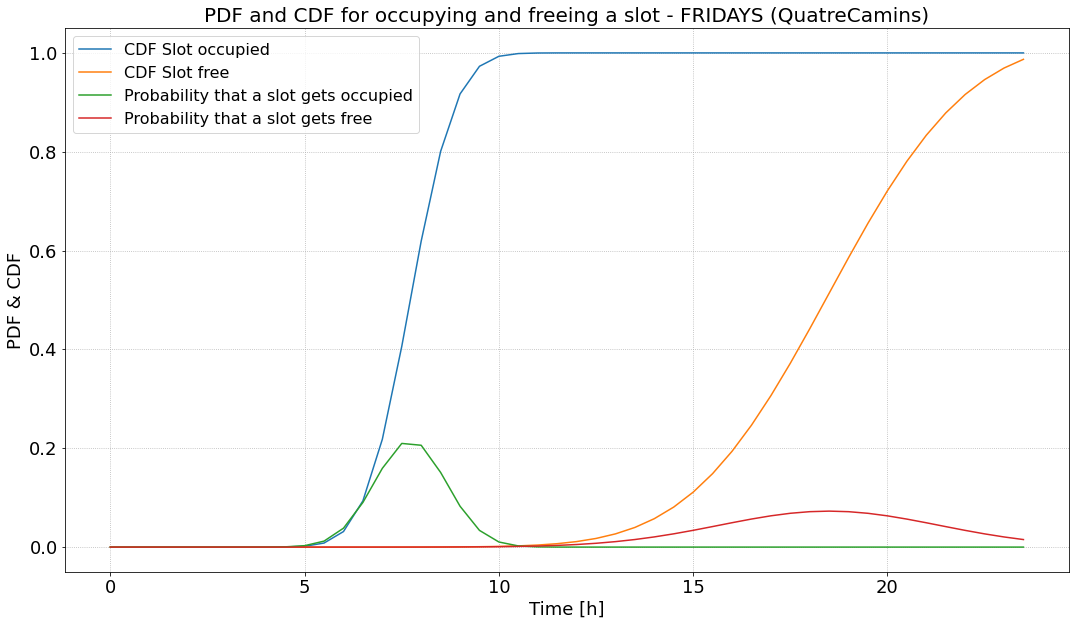

In [108]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta#/sum(resta)
fig = plt.figure(figsize=(18,10))
plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
plt.plot(time, cdf1_fri, label="CDF Slot occupied")
plt.plot(time, cdf2_fri, label="CDF Slot free")
plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left")

plt.legend(fontsize=16)

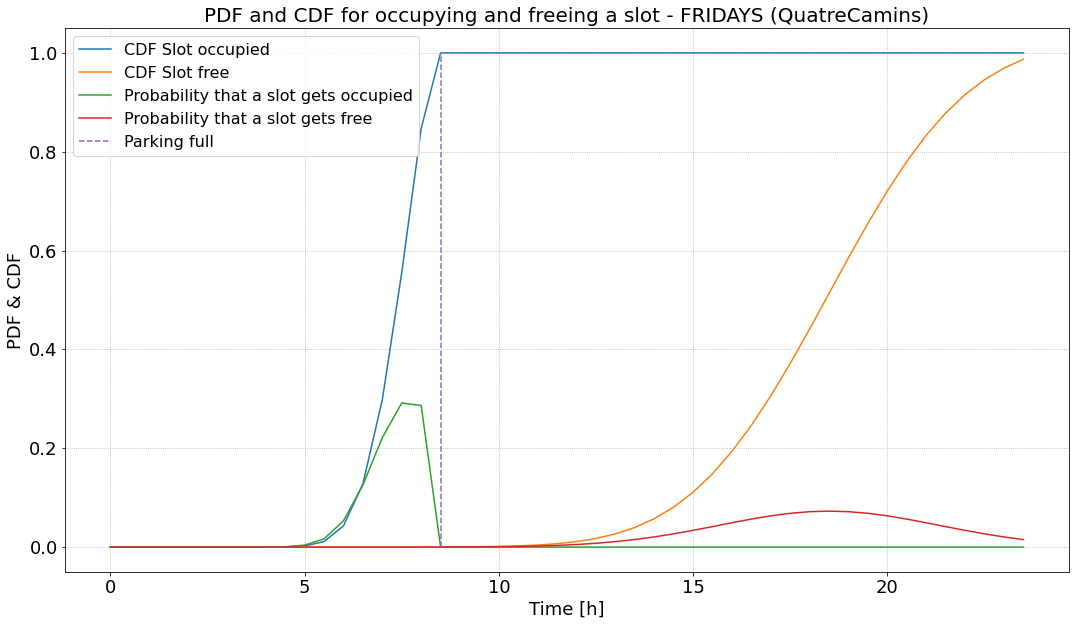

In [204]:
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
prototype_math_arr_friday=cdf1_fri.copy()

ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridayth)
tn1_fri[cdf1_fri>optimal_params_fridayth] =0
cdf1_fri[cdf1_fri>optimal_params_fridayth] = optimal_params_fridayth
cdf1_fri = cdf1_fri/optimal_params_fridayth

cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])
prototype_math_dep_friday=cdf2_fri
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta_fri#/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

fig = plt.figure(figsize=(18,10))
plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
plt.plot(time2, cdf1_fri, label="CDF Slot occupied")
plt.plot(time2, cdf2_fri, label="CDF Slot free")
plt.plot(time2, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
plt.plot(time2, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
#plt.plot(time2, cdf1_wd_ap, label="Cummulative probability arrival approx")
#plt.plot(time2, cdf2_wd_ap, label="Cummulative probability departure approx")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left");

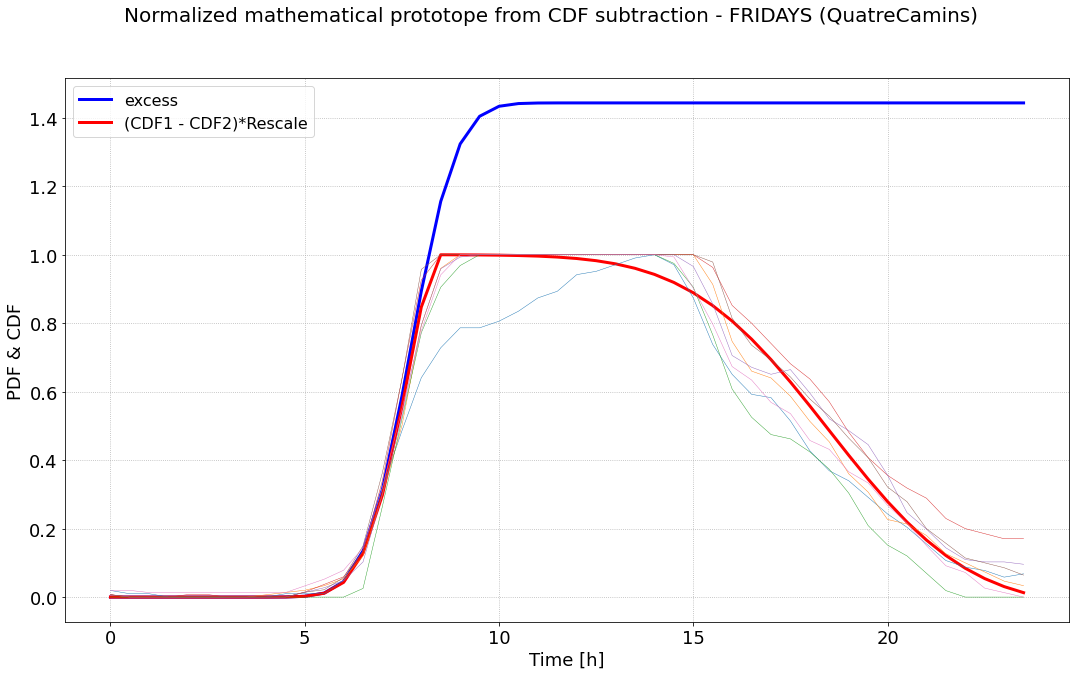

In [205]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time, prototype_math_arr_friday/optimal_params_fridaytn.x[idx_th], linewidth=3, color='blue', label="excess")
plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
for i in range(0,len(training_fridays_norm)):
    plt.plot(time, training_fridays_norm[i], linewidth=0.45)
plt.legend(fontsize=16);

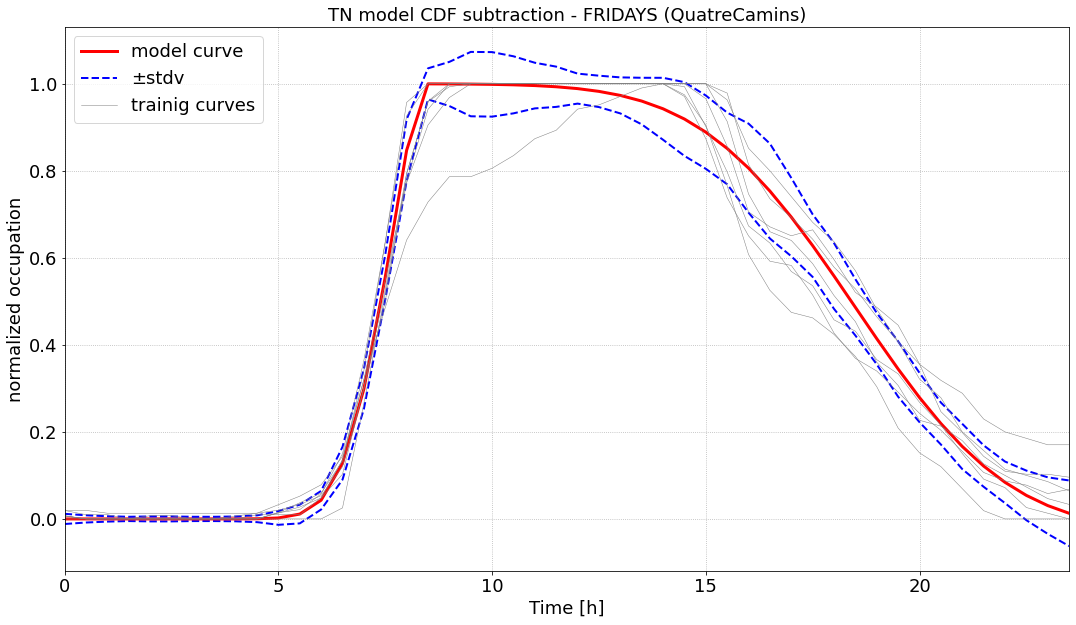

In [206]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

In [146]:
bol_plot_individual_fits = False
if bol_plot_individual_fits:
    tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
    tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    for ii in range(0,len(training_fridays_norm)):
        idx_th=ii+4

        cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])


        dayisFull=training_fridays_isfull[ii]
        if dayisFull:
            print(optimal_params_fridaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] =0
            cdf1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] = optimal_params_fridaytn.x[idx_th]
            cdf1_fri = cdf1_fri/optimal_params_fridaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
        prototype_math_friday = resta_fri#/sum(resta_fri)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_fridays_norm)):
        plt.plot(time, training_fridays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### WEEKENDS

In [147]:
parameters_tn = np.array([.2 ,.05,.7,.1])
errors = np.ones(np.shape(training_weekends_norm))    
if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
    #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='SLSQP',
    #                                   bounds=((0, None), (0, None),(0, None),(0, None)),
    #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
    optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors),
                                    method='SLSQP',
                                    bounds=((0, None), (0, None),(0, None),(0, None)),
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
else:
    #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='Nelder-Mead',
    #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})     
    
    optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


Optimization terminated successfully.
         Current function value: 10.398745
         Iterations: 7701
         Function evaluations: 12491


In [148]:
var_weekendtn = np.mean(errors)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors,0))
print('stdv per time-step')
for i in stdv_weekend30mins:
    print('\t' + str(i))

global stdv 0.16456

stdv per time-step
	0.19850395937537388
	0.1530936366759649
	0.13640706847314008
	0.13577502433435762
	0.13139043094626993
	0.13188446746978275
	0.1269320101526142
	0.12848293622729046
	0.1161864306347378
	0.11318816057251897
	0.10924815139407881
	0.11708768781250685
	0.10198422756472264
	0.08573018893820901
	0.09701982292951876
	0.10474719495807493
	0.10826145577686998
	0.10038959249610879
	0.12123789990180368
	0.1295959631452565
	0.15588708010896984
	0.1328104706750024
	0.12684024723099416
	0.15261219795933562
	0.17189509741752804
	0.18490440214824008
	0.13284712756036615
	0.13737130839057932
	0.11582306444694374
	0.17422857630912447
	0.1939730700572757
	0.17193029940026272
	0.14939900420119467
	0.1428880780090121
	0.13843747766078132
	0.14487149140876154
	0.19085039408548488
	0.20314084902773863
	0.22720086542691972
	0.2680762222910402
	0.27196836484370407
	0.26222947803308827
	0.268937770452034
	0.27203659634849137
	0.24047531399882252
	0.1791264093331493
	0.15

In [149]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([4.23756984e-01, 1.20748554e-01, 6.40233090e+04, 1.10398231e+02])

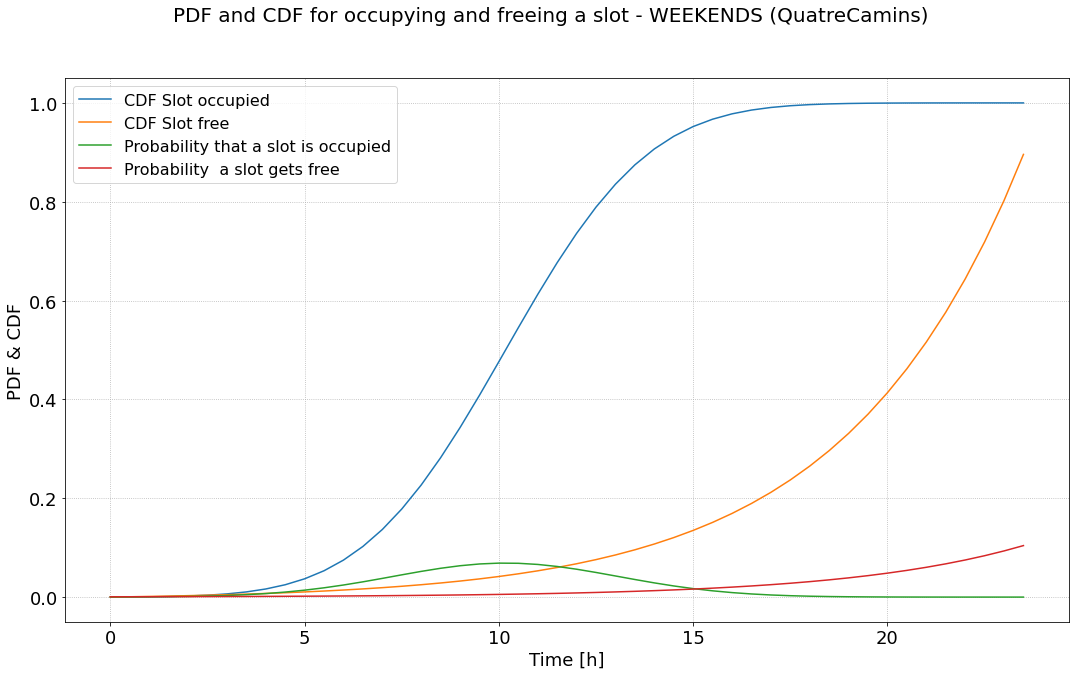

In [150]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we#/sum(resta_we)
fig = plt.figure(figsize=(18,10))
fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
plt.plot(time, cdf1_we, label="CDF Slot occupied")
plt.plot(time, cdf2_we, label="CDF Slot free")
plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left")

plt.legend(fontsize=16)

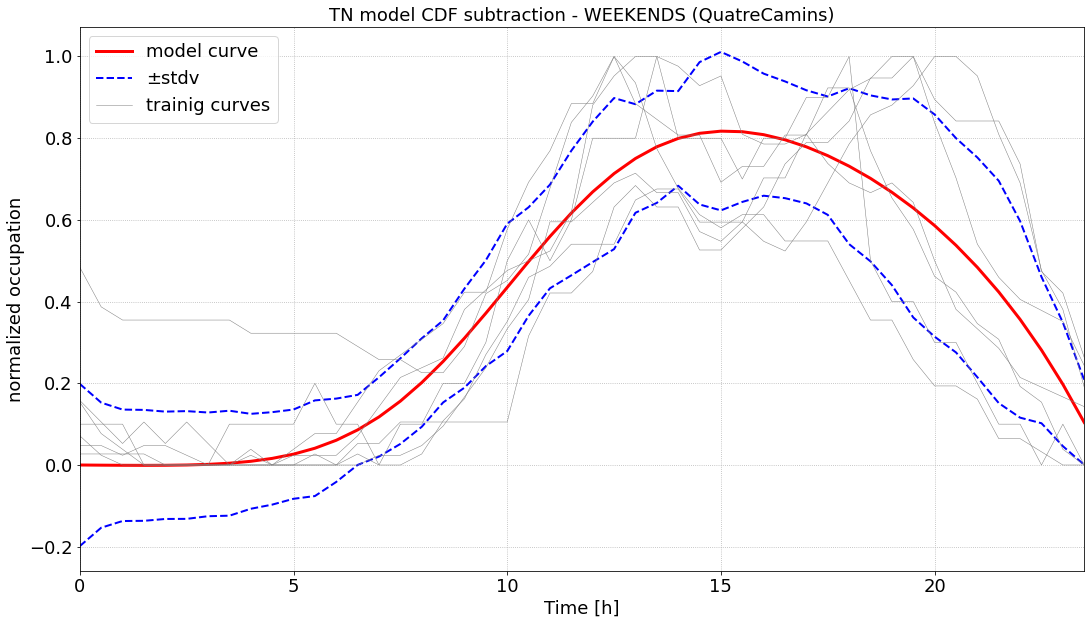

In [151]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [212]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS QuatreCamins -----------
Mean Arrival Time   = 07:31h
stdv Arrival        =  0:52h
Mean Departure Time = 19:24h
stdv Departure      =  1:51h
0.795802575658487
Parking full        = 08:30h
--------- FRIDAYS QuatreCamins -----------
Mean Arrival Time   = 07:43h
stdv Arrival        =  0:55h
Mean Departure Time = 18:29h
stdv Departure      =  2:49h
0.7308314807301474
Parking full        = 08:30h
--------- WEEKENDS QuatreCamins -----------
Mean Arrival Time   = 10:10h
stdv Arrival        =  2:53h
Mean Departure Time = 1536559:24h
stdv Departure      = 2649:33h


In [213]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

tn_arr_weekday_n = prototype_math_arr_weekday
tn_dep_weekday_n = prototype_math_dep_weekday
tn_arr_friday_n = prototype_math_arr_friday
tn_dep_friday_n = prototype_math_dep_friday

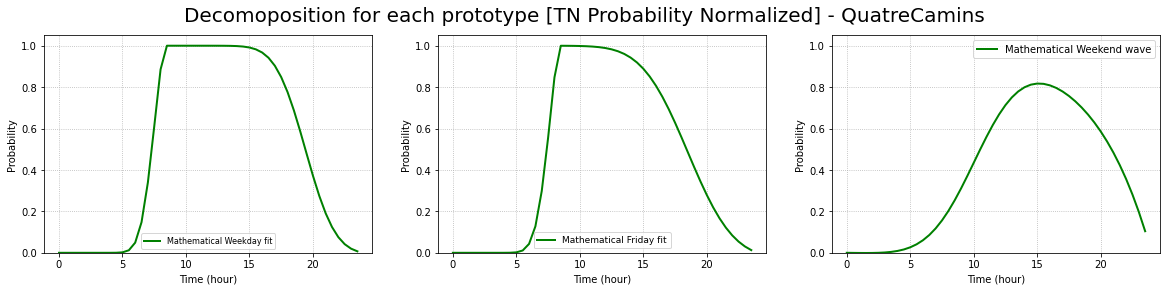

In [214]:
ymax=1.05
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [TN Probability Normalized] - ' + current_parking, fontsize=20)

# for ii in range(len(training_weekdays_norm)):
#     ax[0].plot(time,training_weekdays_norm[ii], linewidth='0.5')
ax[0].plot(time2, tn_weekday_n, linewidth=2, color= 'green', label='Mathematical Weekday fit')
ax[0].set_ylim([0,ymax])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays_norm)):
#     ax[1].plot(time,training_fridays_norm[ii], linewidth='0.5')
ax[1].plot(time2, tn_friday_n, linewidth=2, color= 'green', label='Mathematical Friday fit')
ax[1].set_ylim([0,ymax])
ax[1].grid(linestyle='dotted')
ax[1].legend(fontsize=9)
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Probability')

# for ii in range(len(training_weekends_norm)):
#      ax[2].plot(time,training_weekends_norm[ii], linewidth='0.5')
ax[2].plot(time2, tn1_weekend_n, linewidth=2, color='green', label='Mathematical Weekend wave')
ax[2].set_ylim([0,ymax])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability');

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [215]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_max + weekday_offset
tn_arr_weekday = tn_arr_weekday_n*weekday_max + weekday_offset
tn_dep_weekday = tn_dep_weekday_n*weekday_max #+ weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_max + friday_offset
tn_arr_friday = tn_arr_friday_n*friday_max + friday_offset
tn_dep_friday = tn_dep_friday_n*friday_max #+ friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_max + weekend_offset 



In [216]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

______MEAN________
5.066463312660243
4.660707946301489
5.3365452962205735
8.060159975741533
14.964702013202748
9.149935492971593
9.604299746142273
______STDV________
2.2991119187099
1.9470246127064204
3.878830916765567
5.191267778151059
8.57115009853841
1.740415739284576
1.7165697495213785


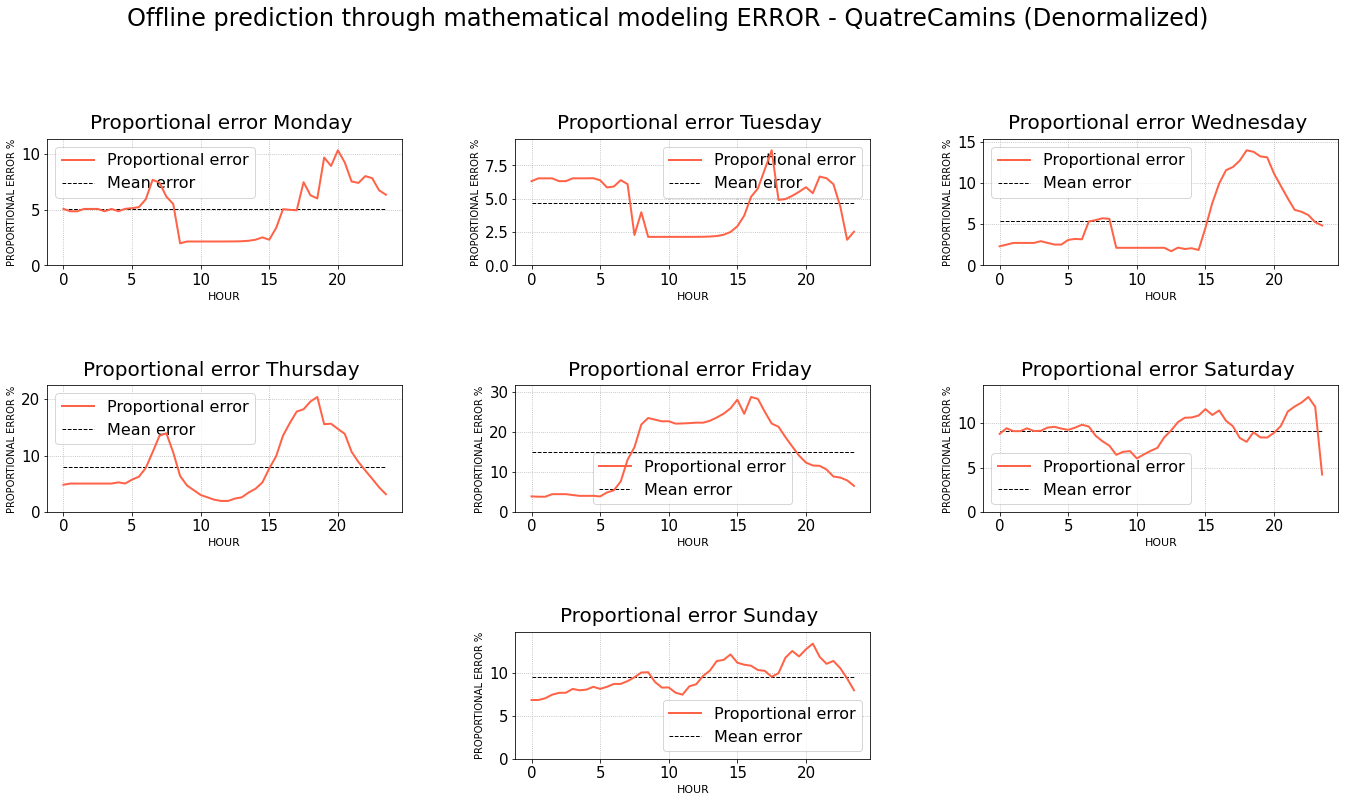

In [217]:


error_monday_tn = compute_testing_prop_errorM(testing_mondays, tn_weekday, max_value)
error_tuesday_tn = compute_testing_prop_errorM(testing_tuesdays, tn_weekday, max_value)
error_wednesday_tn = compute_testing_prop_errorM(testing_wednesdays, tn_weekday, max_value)
error_thursday_tn = compute_testing_prop_errorM(testing_thursdays, tn_weekday, max_value)
error_friday_tn = compute_testing_prop_errorM(testing_fridays, tn_friday, max_value)
error_saturday_tn = compute_testing_prop_errorM(testing_saturdays, tn1_weekend, max_value)
error_sunday_tn = compute_testing_prop_errorM(testing_sundays, tn1_weekend, max_value)



    
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Offline prediction through mathematical modeling ERROR - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 0, 0, time, error_monday_tn, mean_Monday, 
                 'Proportional error Monday ', 'Monday')

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 0, 1, time, error_tuesday_tn, mean_Tuesday, 
                 'Proportional error Tuesday ', 'Tuesday')

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 0, 2, time, error_wednesday_tn, mean_Wednesday, 
                 'Proportional error Wednesday ', 'Wednesday')

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 1, 0, time, error_thursday_tn, mean_Thursday, 
                 'Proportional error Thursday ', 'Thursday')

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 1, 1, time, error_friday_tn, mean_Friday, 
                 'Proportional error Friday ', 'Friday')

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 1, 2, time, error_saturday_tn, mean_Saturday, 
                 'Proportional error Saturday ', 'Saturday')

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 2, 1, time, error_sunday_tn, mean_Sunday, 
                 'Proportional error Sunday ', 'Sunday')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
fig.tight_layout(pad=5.0)
for ax in ax.flat:
    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
    ax.set_xlabel('HOUR', fontsize=11)


print('______MEAN________')    

print(mean_Monday[0])
print(mean_Tuesday[0])
print(mean_Wednesday[0])
print(mean_Thursday[0])
print(mean_Friday[0])
print(mean_Saturday[0])
print(mean_Sunday[0])

print('______STDV________')

print(np.std(error_monday_tn))
print(np.std(error_tuesday_tn))
print(np.std(error_wednesday_tn))
print(np.std(error_thursday_tn))
print(np.std(error_friday_tn))
print(np.std(error_saturday_tn))
print(np.std(error_sunday_tn))


### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [218]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

In [219]:
def plot_prototype():
    for i in range(0,len(tn_proto)):
        if tn_proto[i] < 0:
            tn_proto[i] = 0
    cont=0
    for i in range(0,len(t_days)):
        t_date=t_dates[cont]
        print(t_date)
        tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
        tn_arr_scaling = get_scaling_factor(limit_hour, t_days[i], tn_arr_proto)
        stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)

        scaled_tn_proto = tn_proto * tn_scaling
        scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling
        scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling

        if max(scaled_tn_arr_proto)>max_value:
            cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
            print(round(cars_could_not_park), "cars could not park")
            scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
            scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-weekday_offset)
        scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

        scaled_stat_proto = hist_weekday_proto.values * stat_scaling
        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        axx=0;
        real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto2, scaled_stat_proto, limit_hour, t_date)
        axx=1;
        errors_plottingM(fig, ax, axx, scaled_tn_proto2, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
        cont=cont+1

#### MONDAY

2020-02-24
17 cars could not park
Real Monday scaled prtotype error:  6.87 %
Real Monday scaled prtotype STDV:  2.4181069487790454
Real Monday scaled TN error:  4.93 %
Real Monday scaled TN STDV:  5.405355677838309
_____________________________________________________________
2020-03-02
31 cars could not park
Real Monday scaled prtotype error:  4.31 %
Real Monday scaled prtotype STDV:  3.9940528572669463
Real Monday scaled TN error:  3.48 %
Real Monday scaled TN STDV:  4.243151597113164
_____________________________________________________________
2020-03-09
52 cars could not park
Real Monday scaled prtotype error:  6.18 %
Real Monday scaled prtotype STDV:  2.535821580107943
Real Monday scaled TN error:  3.1 %
Real Monday scaled TN STDV:  3.711990873100895
_____________________________________________________________


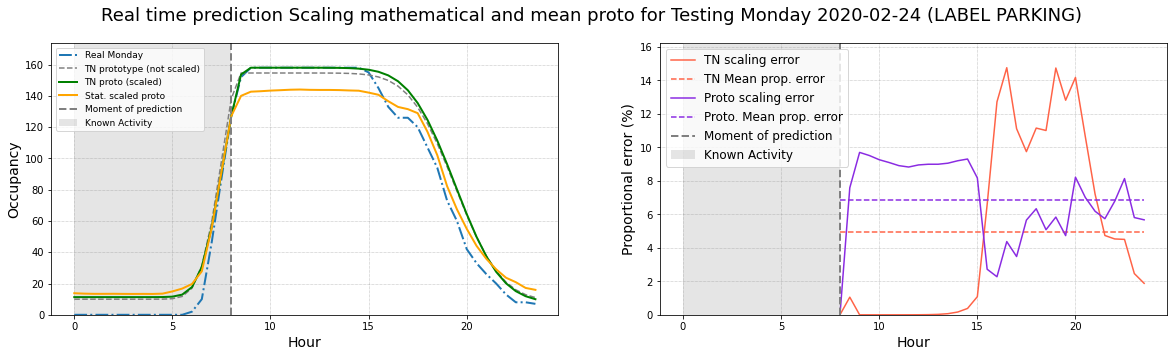

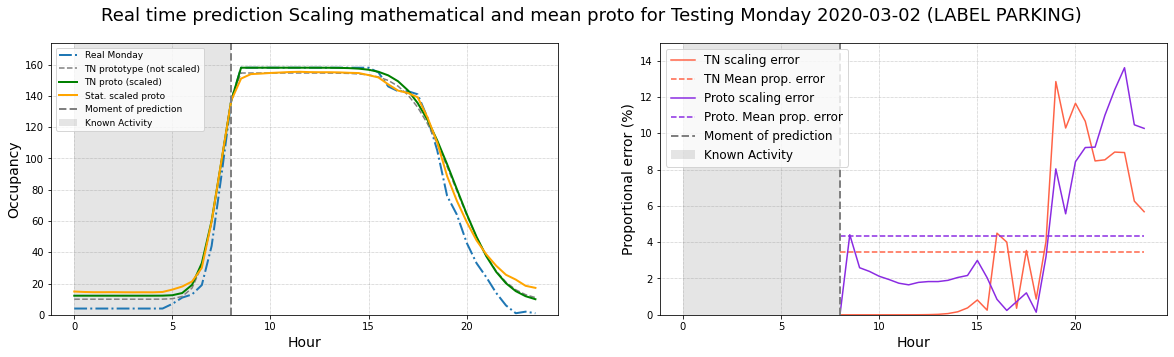

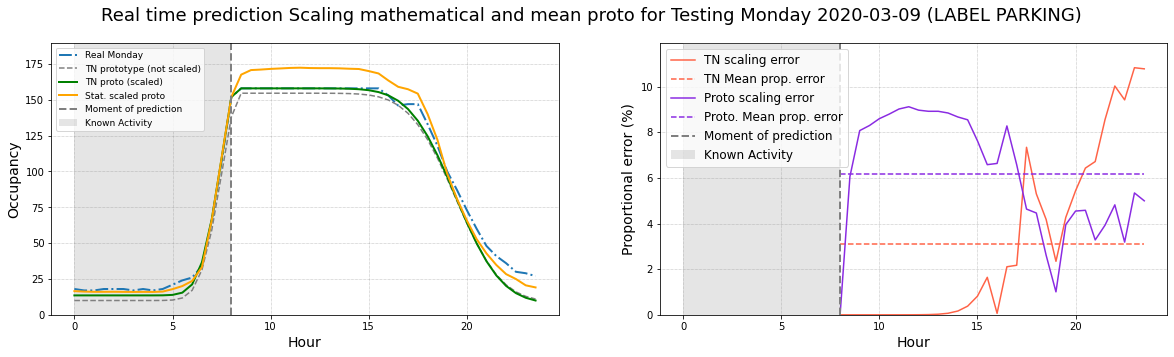

In [220]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 8
day = 'Monday'

tn_arr_proto = tn_arr_weekday
tn_dep_proto = tn_dep_weekday
plot_prototype()

#### TUESDAY

2020-02-25
42 cars could not park
Real Tuesday scaled prtotype error:  3.74 %
Real Tuesday scaled prtotype STDV:  2.180650962057507
Real Tuesday scaled TN error:  2.48 %
Real Tuesday scaled TN STDV:  2.929775834848242
_____________________________________________________________
2020-03-03
33 cars could not park
Real Tuesday scaled prtotype error:  3.9 %
Real Tuesday scaled prtotype STDV:  3.0086331457784254
Real Tuesday scaled TN error:  2.84 %
Real Tuesday scaled TN STDV:  3.652448434901149
_____________________________________________________________
2020-03-10
49 cars could not park
Real Tuesday scaled prtotype error:  4.52 %
Real Tuesday scaled prtotype STDV:  2.5740345299742518
Real Tuesday scaled TN error:  2.32 %
Real Tuesday scaled TN STDV:  2.8616809236705327
_____________________________________________________________


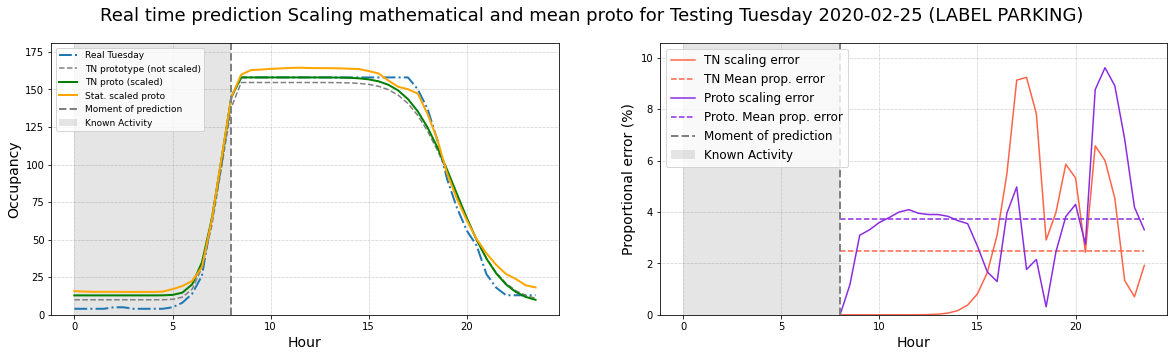

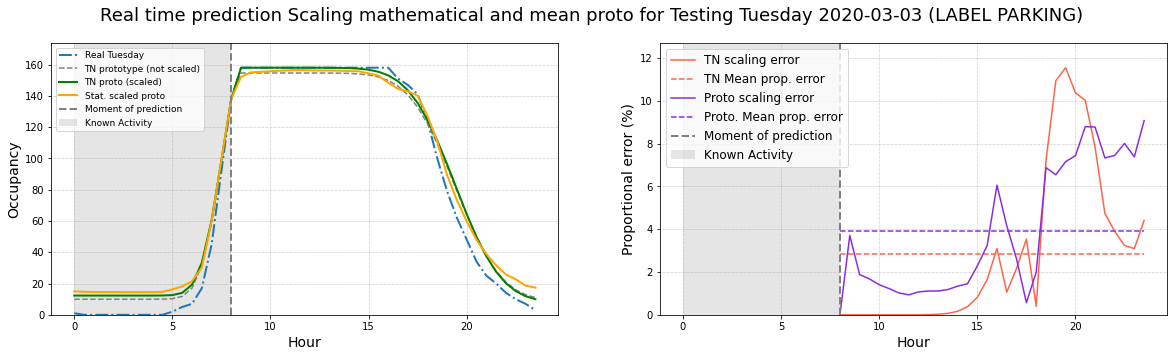

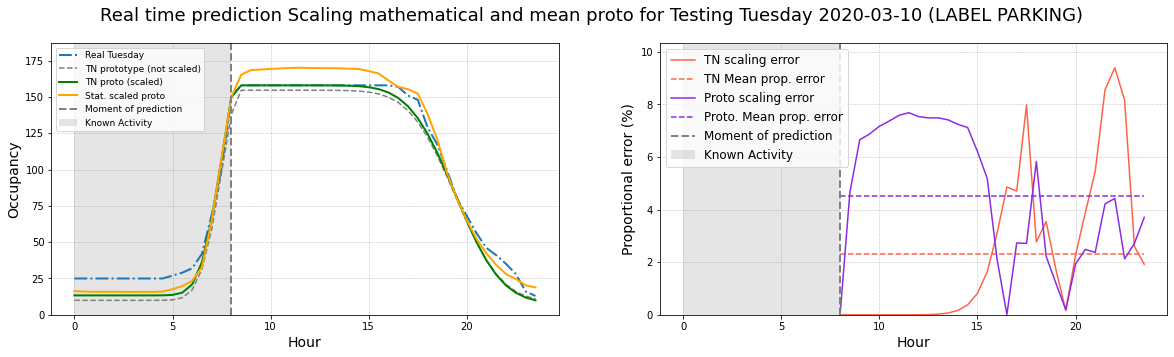

In [221]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 8
day = 'Tuesday'

tn_arr_proto = tn_arr_weekday
tn_dep_proto = tn_dep_weekday
plot_prototype()

### WEDNESDAY

2020-02-26
56 cars could not park
Real Wednesday scaled prtotype error:  6.12 %
Real Wednesday scaled prtotype STDV:  4.279196460207794
Real Wednesday scaled TN error:  2.32 %
Real Wednesday scaled TN STDV:  3.8346978955622038
_____________________________________________________________
2020-03-04
35 cars could not park
Real Wednesday scaled prtotype error:  3.32 %
Real Wednesday scaled prtotype STDV:  3.4345168150361625
Real Wednesday scaled TN error:  2.54 %
Real Wednesday scaled TN STDV:  3.355426320476814
_____________________________________________________________
2020-03-11
44 cars could not park
Real Wednesday scaled prtotype error:  14.84 %
Real Wednesday scaled prtotype STDV:  10.579565826085027
Real Wednesday scaled TN error:  11.24 %
Real Wednesday scaled TN STDV:  11.149810844240731
_____________________________________________________________


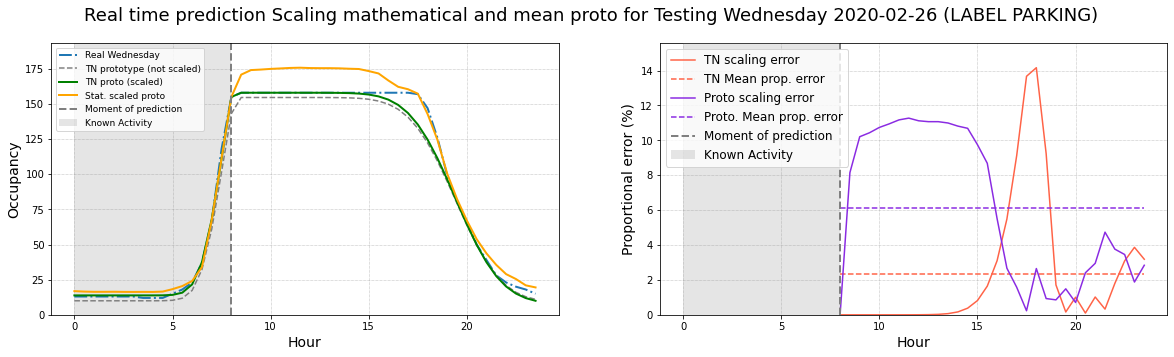

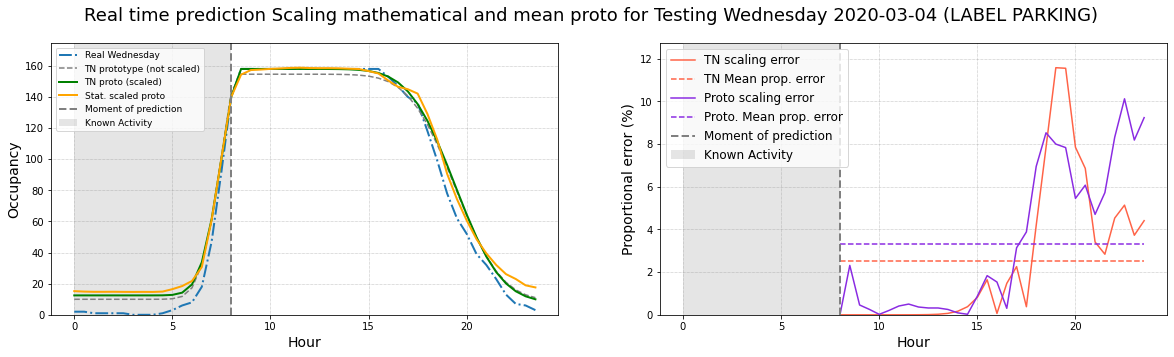

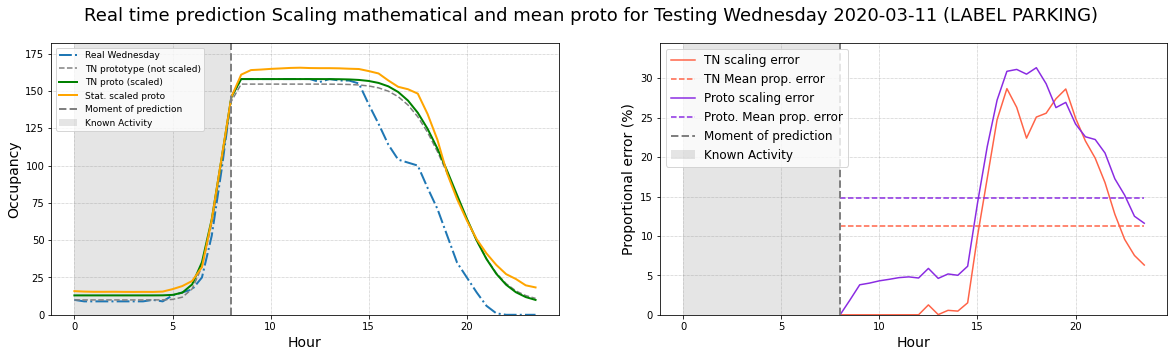

In [184]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 8
day = 'Wednesday'

tn_arr_proto = tn_arr_weekday
tn_dep_proto = tn_dep_weekday
plot_prototype()

### THURSDAY

2020-02-27
56 cars could not park
Real Thursday scaled prtotype error:  7.64 %
Real Thursday scaled prtotype STDV:  4.167969818721817
Real Thursday scaled TN error:  5.02 %
Real Thursday scaled TN STDV:  6.2840521702364605
_____________________________________________________________
2020-03-05
31 cars could not park
Real Thursday scaled prtotype error:  3.35 %
Real Thursday scaled prtotype STDV:  1.9616951841290655
Real Thursday scaled TN error:  1.59 %
Real Thursday scaled TN STDV:  2.0948875894460746
_____________________________________________________________
2020-03-12
Real Thursday scaled prtotype error:  13.73 %
Real Thursday scaled prtotype STDV:  5.322172687926732
Real Thursday scaled TN error:  12.75 %
Real Thursday scaled TN STDV:  11.30570061395234
_____________________________________________________________


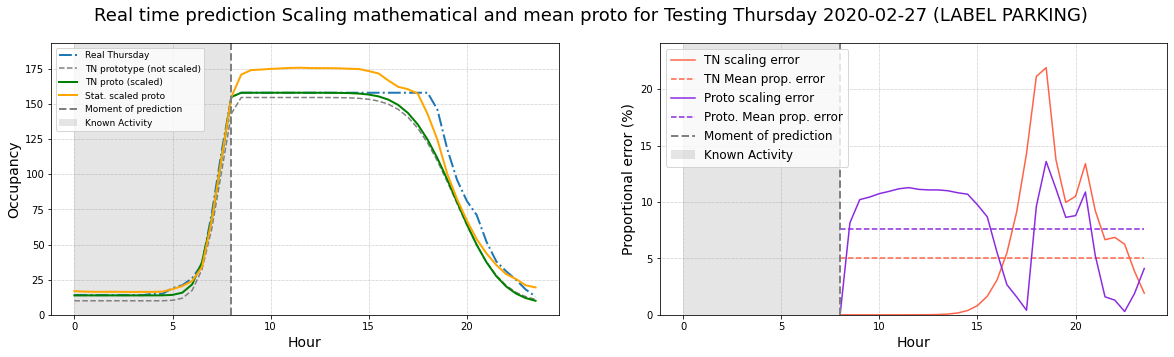

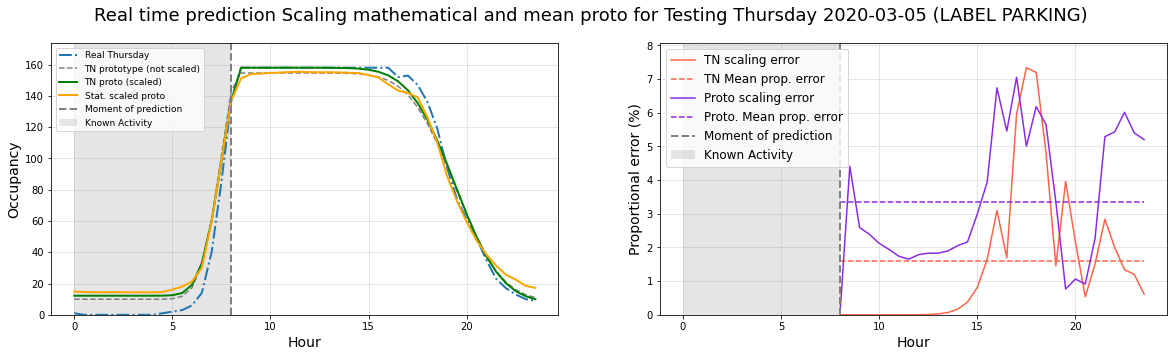

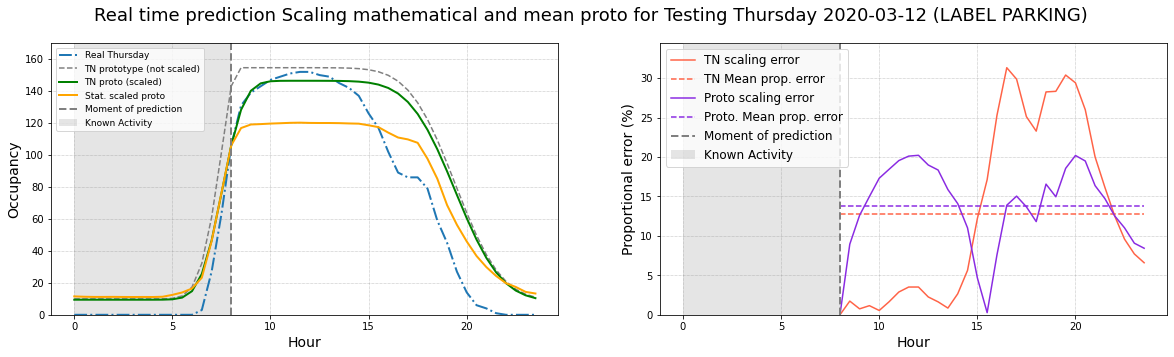

In [185]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 8
day = 'Thursday'

tn_arr_proto = tn_arr_weekday
tn_dep_proto = tn_dep_weekday
plot_prototype()

### FRIDAY

2020-02-28
51 cars could not park
Real Friday scaled prtotype error:  7.12 %
Real Friday scaled prtotype STDV:  6.689128174735353
Real Friday scaled TN error:  2.32 %
Real Friday scaled TN STDV:  2.548578297486739
_____________________________________________________________
2020-03-06
43 cars could not park
Real Friday scaled prtotype error:  9.06 %
Real Friday scaled prtotype STDV:  6.972271177614588
Real Friday scaled TN error:  5.09 %
Real Friday scaled TN STDV:  4.075641219076208
_____________________________________________________________
2020-03-13
Real Friday scaled prtotype error:  9.68 %
Real Friday scaled prtotype STDV:  4.5856279512161455
Real Friday scaled TN error:  7.54 %
Real Friday scaled TN STDV:  5.655462132248567
_____________________________________________________________


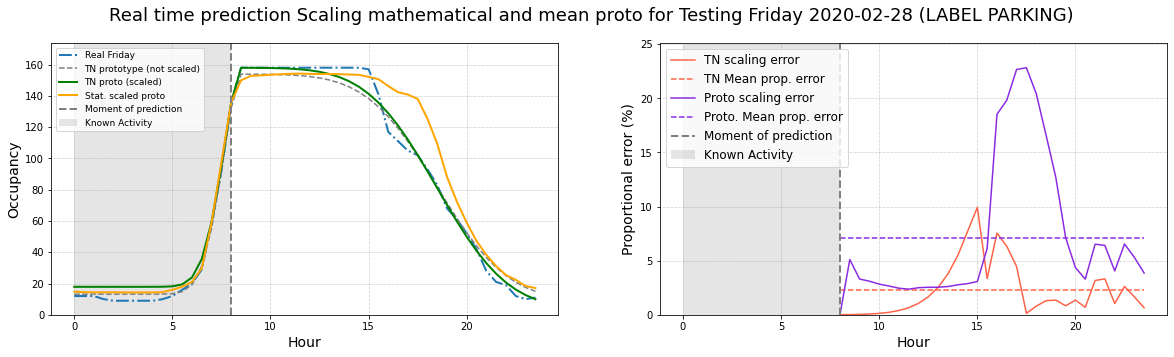

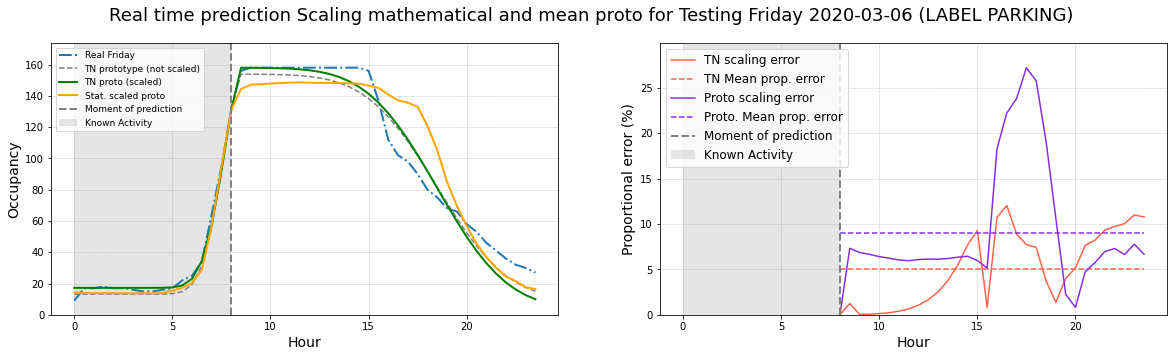

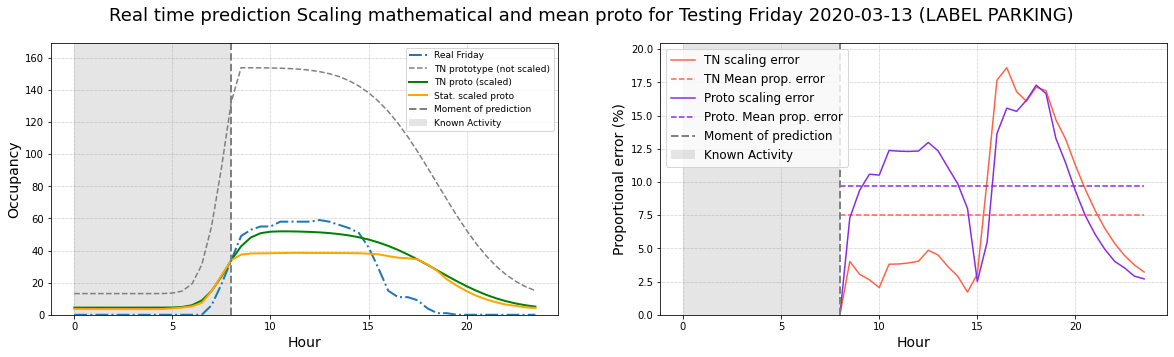

In [222]:
statistic_proto = hist_friday_proto
tn_proto = tn_friday
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 8
day = 'Friday'

tn_arr_proto = tn_arr_friday
tn_dep_proto = tn_dep_friday
plot_prototype() 

### WEEKEND

### SATURDAY

2020-02-22
Real Saturday scaled prtotype error:  2.99 %
Real Saturday scaled prtotype STDV:  2.403517530446649
Real Saturday scaled TN error:  2.85 %
Real Saturday scaled TN STDV:  1.724109526483923
_____________________________________________________________
2020-02-29
Real Saturday scaled prtotype error:  2.1 %
Real Saturday scaled prtotype STDV:  2.1865202491097264
Real Saturday scaled TN error:  2.04 %
Real Saturday scaled TN STDV:  1.763387857140034
_____________________________________________________________


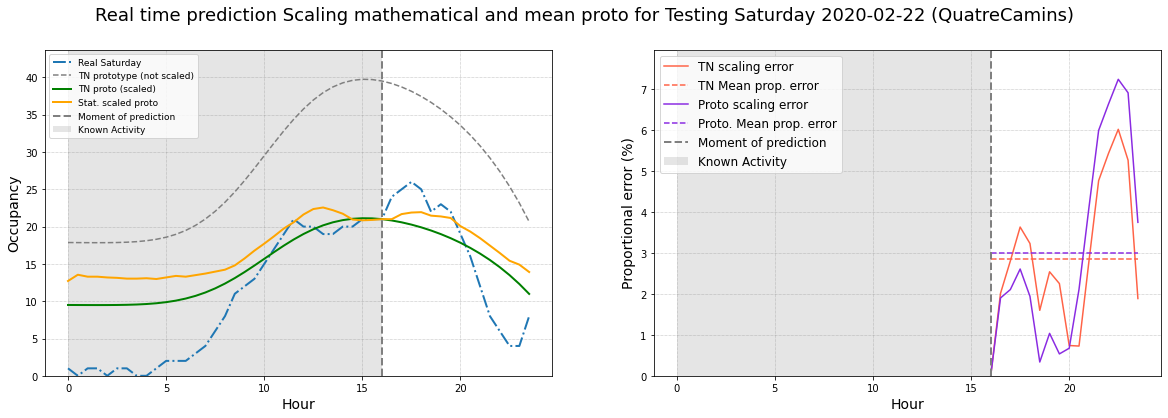

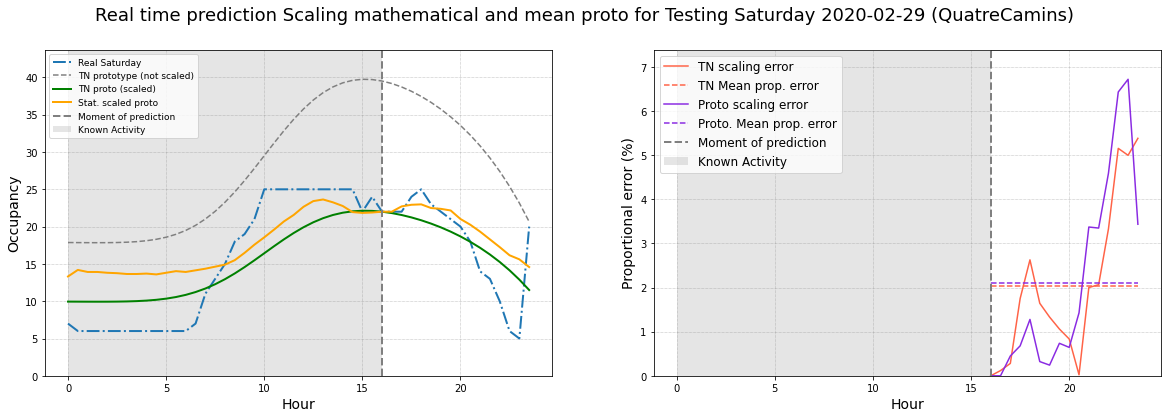

In [188]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

2020-02-23
Real Sunday scaled prtotype error:  3.97 %
Real Sunday scaled prtotype STDV:  2.2198140752279336
Real Sunday scaled TN error:  4.21 %
Real Sunday scaled TN STDV:  1.9508622516963088
_____________________________________________________________
2020-03-01
Real Sunday scaled prtotype error:  3.63 %
Real Sunday scaled prtotype STDV:  2.686988051060659
Real Sunday scaled TN error:  3.31 %
Real Sunday scaled TN STDV:  2.7297754783622574
_____________________________________________________________
2020-03-08
Real Sunday scaled prtotype error:  2.81 %
Real Sunday scaled prtotype STDV:  2.256061162461584
Real Sunday scaled TN error:  2.33 %
Real Sunday scaled TN STDV:  1.9179839708289363
_____________________________________________________________


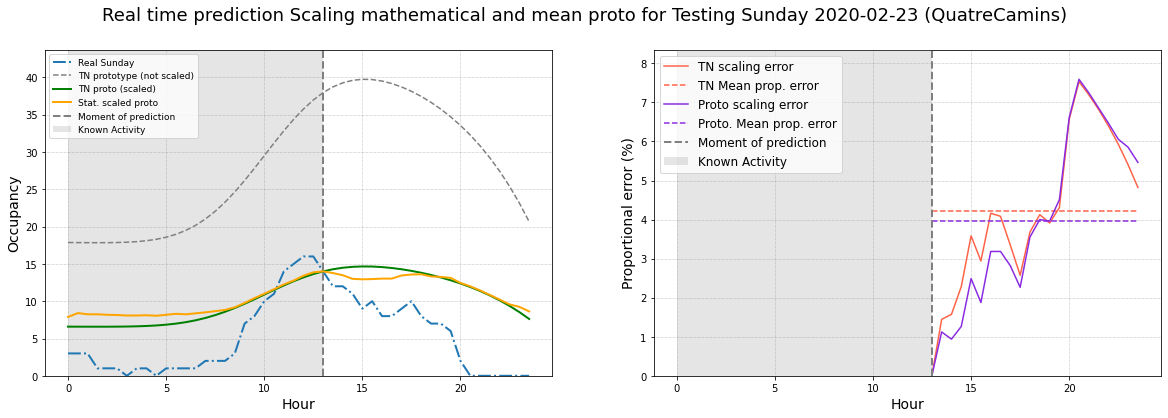

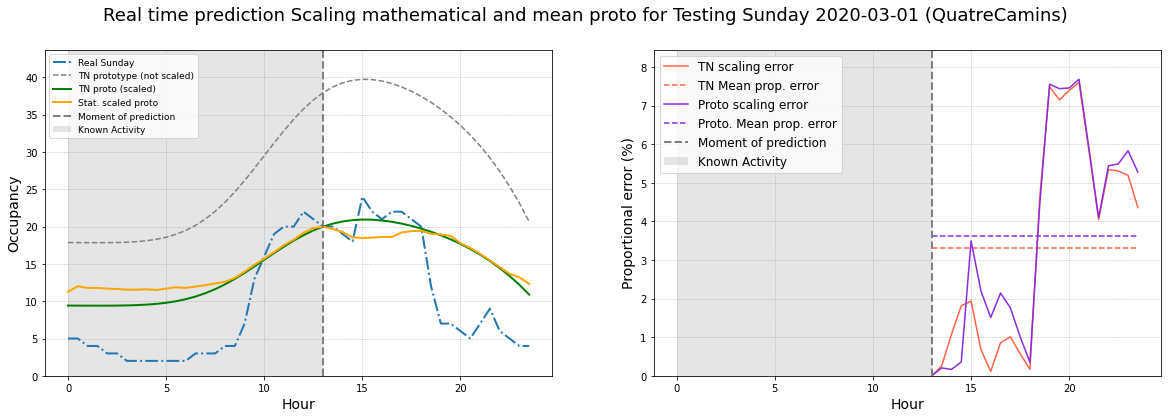

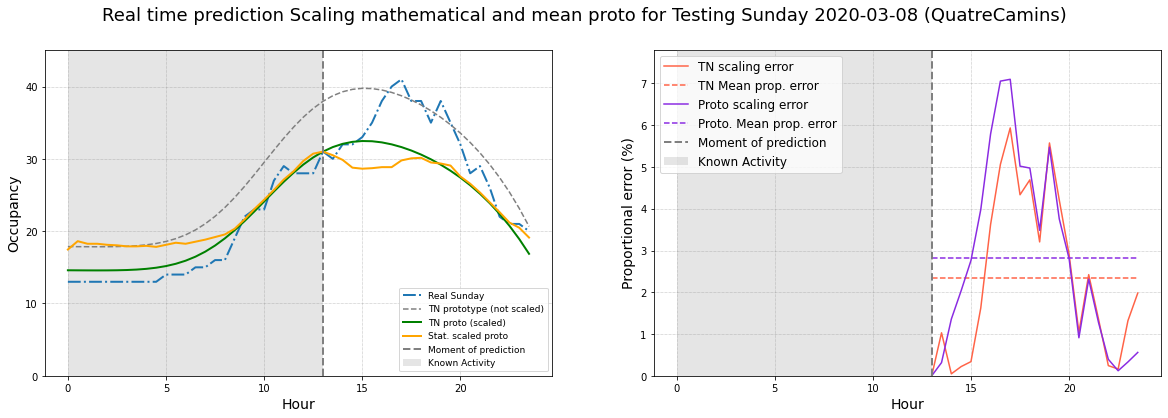

In [189]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
    
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

# Store protos, params, areas and offsets

In [131]:
# df_prototypes = pd.read_csv('data/prototypes_new.csv')
# index = 0

# weekday_tn_params = ','.join(str(e) for e in list(res_weekday.x))
# friday_tn_params  = ','.join(str(e) for e in list(res_friday.x))
# weekend_tn_params = ','.join(str(e) for e in list(res_weekend.x))

# weekday_mean_area = weekday_area
# friday_mean_area  = friday_area
# weekend_mean_area = weekend_area

# weekday_mean_offset = weekday_offset
# friday_mean_offset  = friday_offset
# weekend_mean_offset = weekend_offset

# total_wave_weekday_s = ','.join(str(e) for e in tn_weekday.tolist())
# total_wave_weekend_s = ','.join(str(e) for e in tn1_weekend.tolist())
# total_wave_friday_s  = ','.join(str(e) for e in tn_friday.tolist())

# historical_weekday_s = ','.join(str(e) for e in hist_weekday_proto.tolist())
# historical_weekend_s = ','.join(str(e) for e in hist_weekend_proto.tolist())
# historical_friday_s  = ','.join(str(e) for e in hist_friday_proto.tolist())


# df_prototypes.at[index,'CDF subtraction_weekday_proto'] = total_wave_weekday_s
# df_prototypes.at[index,'CDF subtraction_friday_proto']  = total_wave_friday_s
# df_prototypes.at[index,'CDF subtraction_weekend_proto'] = total_wave_weekend_s

# df_prototypes.at[index,'CDF subtraction_weekday_params'] = weekday_tn_params
# df_prototypes.at[index,'CDF subtraction_friday_params']  = friday_tn_params
# df_prototypes.at[index,'CDF subtraction_weekend_params'] = weekend_tn_params

# df_prototypes.at[index,'CDF subtraction_weekday_area'] = weekday_mean_area
# df_prototypes.at[index,'CDF subtraction_friday_area']  = friday_mean_area
# df_prototypes.at[index,'CDF subtraction_weekend_area'] = weekend_mean_area

# df_prototypes.at[index,'CDF subtraction_weekday_offset'] = weekday_mean_offset
# df_prototypes.at[index,'CDF subtraction_friday_offset']  = friday_mean_offset
# df_prototypes.at[index,'CDF subtraction_weekend_offset'] = weekend_mean_offset

# df_prototypes.at[index,'Historical_weekday_proto'] = historical_weekday_s
# df_prototypes.at[index,'Historical_weekend_proto'] = historical_weekend_s
# df_prototypes.at[index,'Historical_friday_proto']  = historical_friday_s

# df_prototypes.to_csv("data/final_prototypes.csv", index=False)
# df_prototypes

In [132]:
# How to read the prorotypes: 
# string = exportable_df.at[0,'CDF subtraction_weekday_proto']
# list_of_strings = string.split(',')
# final_list = list(np.float_(list_of_strings))

In [133]:
# import pandas as pd
# df_prototypes_2 = pd.read_csv('data/prototypes_new.csv')
# new_row = {'Location':'Cerdanyola'}
# #append row to the dataframe
# df_prototypes_2 = df_prototypes_2.append(new_row, ignore_index=True)
# df_prototypes_2

In [134]:
# df_prototypes_2.to_csv("data/prototypes_new.csv", index=False)
# day = 'Monday'
# date = '2020-02-24'
# real_day = mean_of_day(day,date)
# real_day.values

In [135]:
# hist_friday_proto.tolist()